In [1]:
from pyspark.sql import SparkSession, functions, types
spark = SparkSession.builder.appName('temp').getOrCreate()
assert spark.version >= '2.4' # make sure we have Spark 2.4+
spark.sparkContext.setLogLevel('WARN')
sc = spark.sparkContext

In [1]:
import pandas as pd
from dataprep.eda import plot
import matplotlib.pyplot as plt

NumExpr defaulting to 4 threads.


# Read Data

In [74]:
patient = pd.read_csv("mimic/PATIENTS.csv")

In [31]:
admission = pd.read_csv("mimic/ADMISSIONS.csv")
diagnoses_d = pd.read_csv("mimic/D_ICD_DIAGNOSES.csv")
diagnoses = pd.read_csv("mimic/DIAGNOSES_ICD.csv")
icu = pd.read_csv("mimic/ICUSTAYS.csv")
prescriptions = pd.read_csv("mimic/PRESCRIPTIONS.csv")

## Data ETL

In [96]:
# Assigne diagnoses groups according to ICD9_CODE
def assign_category(icd9_code):
    try:
        code = int(icd9_code)
        if code >= 10000:
            code = code // 100
        elif code >= 1000:
            code = code // 10
        else:
            pass
        if code <= 139:
            return 0
        if code <= 239:
            return 1
        if code <= 279:
            return 2
        if code <= 289:
            return 3
        if code <= 319:
            return 4
        if code <= 389:
            return 5
        if code <= 459:
            return 6
        if code <= 519:
            return 7
        if code <= 579:
            return 8
        if code <= 629:
            return 9
        if code <= 679:
            return 10
        if code <= 709:
            return 11
        if code <= 739:
            return 12
        if code <= 759:
            return 13
        if code <= 779:
            return 14
        if code <= 799:
            return 15
        return 16
    except:
        return 17

D_Category = {
    0: 'infectious and parasitic diseases',
    1: 'neoplasms',
    2: 'endocrine, nutritional and metabolic diseases, and immunity disorders',
    3: 'diseases of the blood and blood-forming organs',
    4: 'mental disorders',
    5: 'diseases of the nervous system and sense organs',
    6: 'diseases of the circulatory system',
    7: 'diseases of the respiratory system',
    8: 'diseases of the digestive system',
    9: 'diseases of the genitourinary system',
    10: 'complications of pregnancy, childbirth, and the puerperium',
    11: 'diseases of the skin and subcutaneous tissue',
    12: 'diseases of the musculoskeletal system and connective tissue',
    13: 'congenital anomalies',
    14: 'certain conditions originating in the perinatal period',
    15: 'symptoms, signs, and ill-defined conditions',
    16: ' injury and poisoning',
    17: 'external causes of injury and supplemental classification'
}
# Add Diagnoses group column
diagnoses['category'] = diagnoses['ICD9_CODE'].apply(assign_category)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/p

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,...,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,age,GENDER
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,...,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1,-1,F
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,...,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1,-1,M
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,...,CATHOLIC,MARRIED,WHITE,NaN,NaN,BRAIN MASS,0,1,-1,M
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,...,PROTESTANT QUAKER,SINGLE,WHITE,NaN,NaN,INTERIOR MYOCARDIAL INFARCTION,0,1,-1,M
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,...,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1,-1,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58971,58592,98794,190603,2127-11-07 11:00:00,2127-11-11 14:30:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,...,CATHOLIC,MARRIED,WHITE,NaN,NaN,AORTIC STENOSIS\AORTIC VALVE REPLACEMENT /SDA,0,1,-1,M
58972,58593,98797,105447,2132-12-24 20:06:00,2132-12-25 12:00:00,2132-12-25 12:00:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicare,...,CATHOLIC,WIDOWED,WHITE,2132-12-24 18:53:00,2132-12-24 21:41:00,ALTERED MENTAL STATUS,1,1,88,M
58973,58594,98800,191113,2131-03-30 21:13:00,2131-04-02 15:02:00,NaN,EMERGENCY,CLINIC REFERRAL/PREMATURE,HOME,Private,...,NOT SPECIFIED,SINGLE,WHITE,2131-03-30 19:44:00,2131-03-30 22:41:00,TRAUMA,0,1,-1,F
58974,58595,98802,101071,2151-03-05 20:00:00,2151-03-06 09:10:00,2151-03-06 09:10:00,EMERGENCY,CLINIC REFERRAL/PREMATURE,DEAD/EXPIRED,Medicare,...,CATHOLIC,WIDOWED,WHITE,2151-03-05 17:23:00,2151-03-05 21:06:00,SAH,1,1,84,F


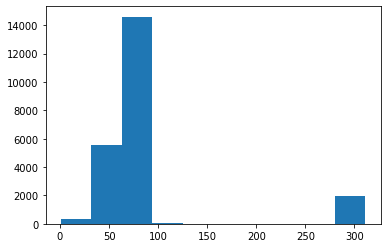

In [77]:
# calculate age of death, if patient survived, set age to negative
patient_dead = patient[patient['EXPIRE_FLAG']==1]
patient_dead['DOB_Y'] = patient_dead['DOB'].apply(lambda x: int(pd.to_datetime(x).strftime('%Y')))
patient_dead['DOD_Y'] = patient_dead['DOD'].apply(lambda x: int(pd.to_datetime(x).strftime('%Y')))
patient_dead['age'] = patient_dead['DOD_Y'] - patient_dead['DOB_Y']
patient_s = patient[patient['EXPIRE_FLAG']==0]
patient_s['age'] = -1
patient_age = pd.concat([patient_dead[['age', 'SUBJECT_ID', 'GENDER']], patient_s[['age', 'SUBJECT_ID', 'GENDER']]])

admission_patient = admission.merge(patient_age, on='SUBJECT_ID')
# death age histogram
death_age = admission_patient['age'][admission_patient['age']>0]
plt.hist(death_age)
admission_patient

# Diagnoses Mortality Analysis

In [89]:
# Overall Mortality Analysis
dead = admission_patient[admission_patient['HOSPITAL_EXPIRE_FLAG']==1]
survived = admission_patient[admission_patient['HOSPITAL_EXPIRE_FLAG']==0]
diag_dead = diagnoses.merge(dead, on='HADM_ID')
diag_survived = diagnoses.merge(survived, on='HADM_ID')
grouped_dead = diag_dead.groupby('ICD9_CODE').size().rename('dead').to_frame()
grouped_survived = diag_survived.groupby('ICD9_CODE').size().rename('survive').to_frame()
dead_survived = grouped_dead.merge(grouped_survived, on='ICD9_CODE', how='outer').fillna(0)
dead_survived['total'] = dead_survived['survive']+dead_survived['dead']
dead_survived

,dead,survive,total
ICD9_CODE,,,
0071,1.0,0.0,1.0
0074,1.0,6.0,7.0
00845,272.0,1172.0,1444.0
00847,1.0,0.0,1.0
00863,1.0,5.0,6.0
...,...,...,...
V9010,0.0,1.0,1.0
V9039,0.0,1.0,1.0
V9081,0.0,3.0,3.0


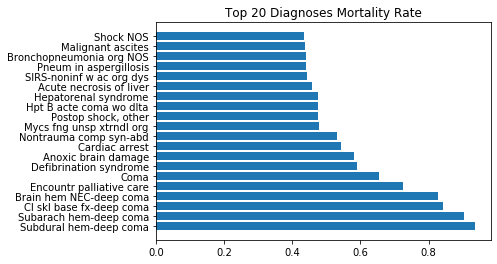

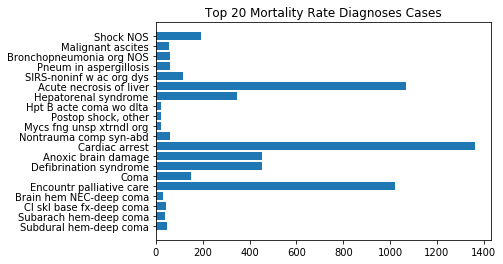

In [122]:
# Mortality Analysis
CASE_THRESHOLD = 20
TOP = 20

dead_survived = dead_survived[dead_survived['total']>CASE_THRESHOLD]
dead_survived['mortality_rate'] = dead_survived['dead']/dead_survived['total']
dead_survived = dead_survived.merge(diagnoses_d, on='ICD9_CODE')
# mortality rate
mortality = dead_survived.sort_values(by='mortality_rate', ascending=False)
show = mortality.head(TOP)
plt.barh(show['SHORT_TITLE'], show['mortality_rate'], align='center')
plt.yticks(show['SHORT_TITLE'])
plt.title('Top '+str(TOP)+' Diagnoses Mortality Rate')
plt.show()

plt.barh(show['SHORT_TITLE'], show['total'], align='center')
plt.yticks(show['SHORT_TITLE'])
plt.title('Top '+str(TOP)+' Mortality Rate Diagnoses Cases')
plt.show()

Selected Diagnosis Analysis

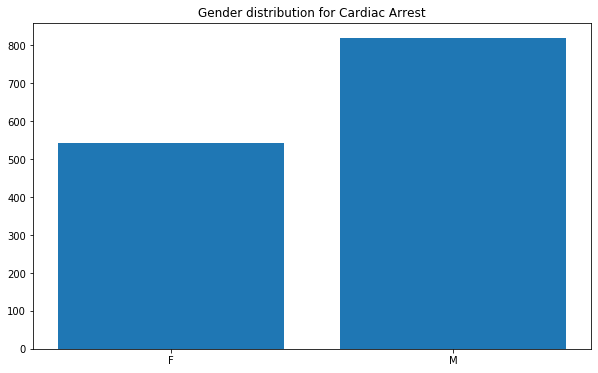

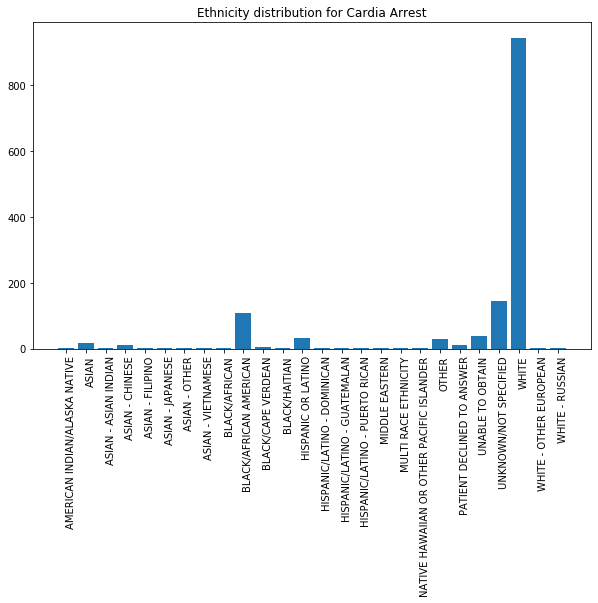

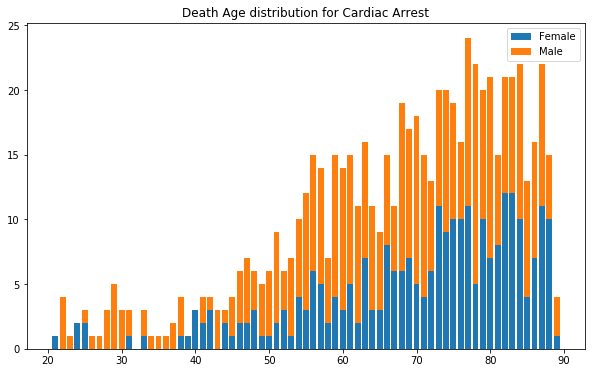

In [236]:
# Cardiac arrest
CODE1 = mortality[mortality['SHORT_TITLE']=='Cardiac arrest'].iloc[0]['ICD9_CODE']
code1_diag = diagnoses[diagnoses['ICD9_CODE']==CODE1]
code1_diag_adm = admission_patient.merge(code1_diag, on='HADM_ID')[['HOSPITAL_EXPIRE_FLAG', 'age', 'GENDER', 'ETHNICITY']]
code1_diag_dead = code1_diag_adm[code1_diag_adm['HOSPITAL_EXPIRE_FLAG']==1]
# ignore age outliers
code1_diag_dead = code1_diag_dead[code1_diag_dead['age']<=100]

# gender distribution
fig1, ax1 = plt.subplots()
data1 = code1_diag_adm.groupby('GENDER').size()
ax1.bar(data1.index.tolist(), data1.tolist())
ax1.set_title('Gender distribution for Cardiac Arrest')
fig1.set_size_inches(10, 6, forward=True)
# ethnicity distribution
fig2, ax2 = plt.subplots()
data2 = code1_diag_adm.groupby('ETHNICITY').size()
ax2.bar(data2.index.tolist(), data2.tolist())
plt.setp(ax2.get_xticklabels(), rotation=90, ha="right",
         rotation_mode="anchor")
fig2.set_size_inches(10, 6, forward=True)
ax2.set_title('Ethnicity distribution for Cardia Arrest')
# death age distribution
fig3, ax3 = plt.subplots()

dataf = code1_diag_dead[code1_diag_dead['GENDER']=='F'].groupby('age').size().rename('female').to_frame()
datam = code1_diag_dead[code1_diag_dead['GENDER']=='M'].groupby('age').size().rename('male').to_frame()
data3 = dataf.merge(datam, on='age', how='outer').fillna(0).reset_index()

p1 = ax3.bar(data3['age'], data3['female'])
p2 = ax3.bar(data3['age'], data3['male'], bottom=data3['female'])
ax3.legend((p1[0], p2[0]), ('Female', 'Male'))
ax3.set_title('Death Age distribution for Cardiac Arrest')
fig3.set_size_inches(10, 6, forward=True)

plt.show();

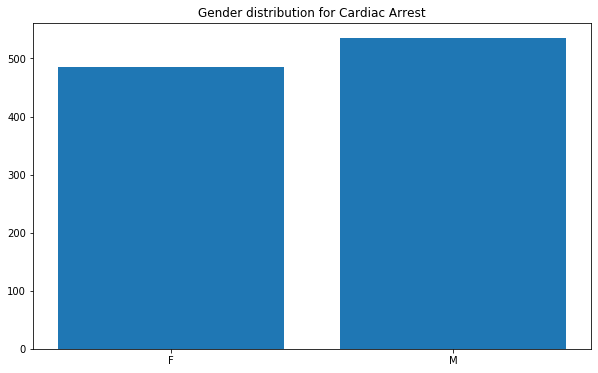

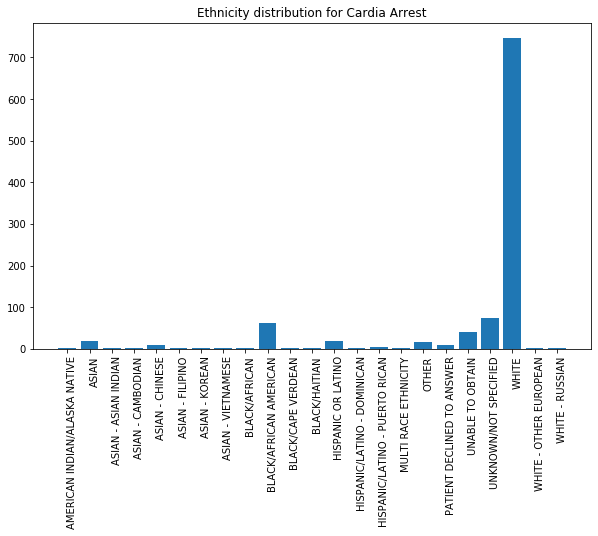

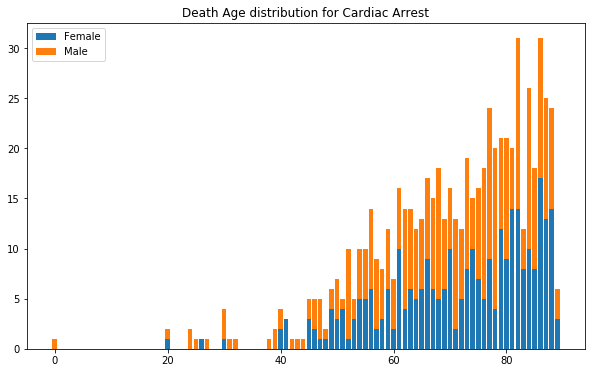

In [237]:
# Encountr palliative care
CODE2 = mortality[mortality['SHORT_TITLE']=='Encountr palliative care'].iloc[0]['ICD9_CODE']
code2_diag = diagnoses[diagnoses['ICD9_CODE']==CODE2]
code2_diag_adm = admission_patient.merge(code2_diag, on='HADM_ID')[['HOSPITAL_EXPIRE_FLAG', 'age', 'GENDER', 'ETHNICITY']]
code2_diag_dead = code2_diag_adm[code2_diag_adm['HOSPITAL_EXPIRE_FLAG']==1]
# ignore age outliers
code2_diag_dead = code2_diag_dead[code2_diag_dead['age']<=100]

# gender distribution
fig1, ax1 = plt.subplots()
data1 = code2_diag_adm.groupby('GENDER').size()
ax1.bar(data1.index.tolist(), data1.tolist())
ax1.set_title('Gender distribution for Cardiac Arrest')
fig1.set_size_inches(10, 6, forward=True)
# ethnicity distribution
fig2, ax2 = plt.subplots()
data2 = code2_diag_adm.groupby('ETHNICITY').size()
ax2.bar(data2.index.tolist(), data2.tolist())
plt.setp(ax2.get_xticklabels(), rotation=90, ha="right",
         rotation_mode="anchor")
fig2.set_size_inches(10, 6, forward=True)
ax2.set_title('Ethnicity distribution for Cardia Arrest')
# death age distribution
fig3, ax3 = plt.subplots()

dataf = code2_diag_dead[code2_diag_dead['GENDER']=='F'].groupby('age').size().rename('female').to_frame()
datam = code2_diag_dead[code2_diag_dead['GENDER']=='M'].groupby('age').size().rename('male').to_frame()
data3 = dataf.merge(datam, on='age', how='outer').fillna(0).reset_index()

p1 = ax3.bar(data3['age'], data3['female'])
p2 = ax3.bar(data3['age'], data3['male'], bottom=data3['female'])
ax3.legend((p1[0], p2[0]), ('Female', 'Male'))
ax3.set_title('Death Age distribution for Cardiac Arrest')
fig3.set_size_inches(10, 6, forward=True)

plt.show();

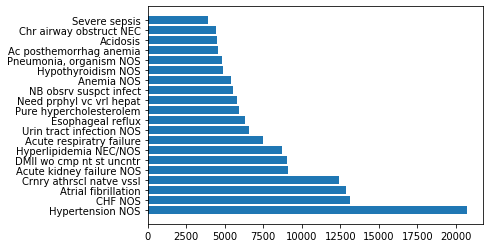

In [116]:
# total cases
total = dead_survived.sort_values(by='total', ascending=False)
show = total.head(20)
plt.barh(show['SHORT_TITLE'], show['total'], align='center')
plt.yticks(show['SHORT_TITLE'])
plt.show()

In [239]:
# Diagnoses Group
Dgroup_dead = diag_dead.groupby('category').size().rename('dead').to_frame()
Dgroup_survived = diag_survived.groupby('category').size().rename('survive').to_frame()
dead_survived_G = Dgroup_dead.merge(Dgroup_survived, on='category', how='outer').fillna(0)
dead_survived_G['total'] = dead_survived_G['survive']+dead_survived_G['dead']
dead_survived_G['mortality_rate'] = dead_survived_G['dead']/dead_survived_G['total']
dead_survived_G['name'] = dead_survived_G.index.map(lambda x: D_Category[x])
dead_survived_G

,dead,survive,total,mortality_rate,name
category,,,,,
0,523,2940,3463,0.151025,infectious and parasitic diseases
1,2727,11527,14254,0.191315,neoplasms
2,8608,60999,69607,0.123666,"endocrine, nutritional and metabolic diseases,..."
3,3536,21726,25262,0.139973,diseases of the blood and blood-forming organs
4,2001,22915,24916,0.080310,mental disorders
5,5076,24703,29779,0.170456,diseases of the nervous system and sense organs
6,17520,127957,145477,0.120431,diseases of the circulatory system
7,8172,36709,44881,0.182082,diseases of the respiratory system
8,5629,33311,38940,0.144556,diseases of the digestive system


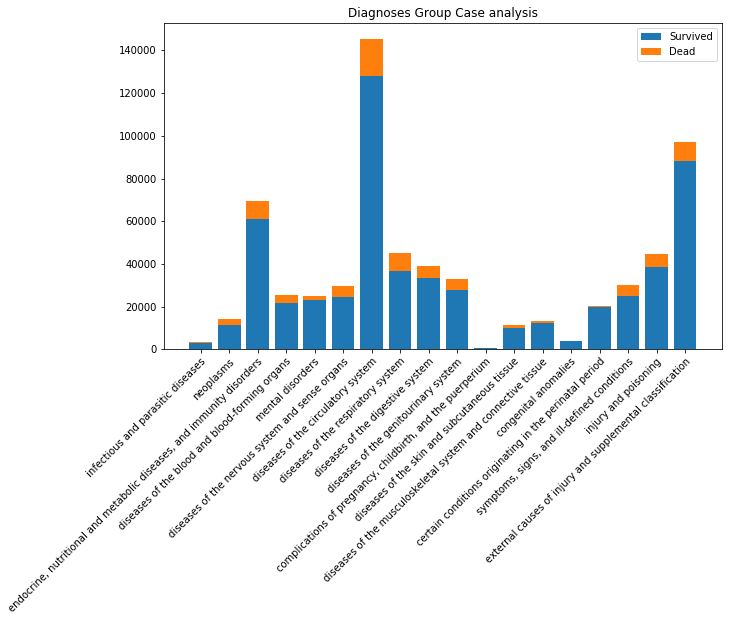

In [242]:
# Diagnoses Group EDA
fig, ax = plt.subplots()

p1 = ax.bar(dead_survived_G['name'], dead_survived_G['survive'])
p2 = ax.bar(dead_survived_G['name'], dead_survived_G['dead'], bottom=dead_survived_G['survive'])
ax.legend((p1[0], p2[0]), ('Survived', 'Dead'))
ax.set_title('Diagnoses Group Case analysis')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
fig.set_size_inches(10, 6, forward=True)
plt.show();